In [78]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from torchvision import datasets, transforms

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [79]:
# データセットの準備
train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transforms.ToTensor())
test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transforms.ToTensor())

train_images = train_dataset.data.numpy()
train_labels = train_dataset.targets.numpy()
test_images = test_dataset.data.numpy()
test_labels = test_dataset.targets.numpy()

In [80]:
# データセットのシェイプの確認
print(train_images.shape)
print(train_labels.shape)
print(test_images.shape)
print(test_labels.shape)

(60000, 28, 28)
(60000,)
(10000, 28, 28)
(10000,)


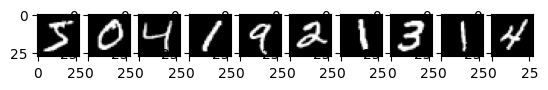

In [81]:
# データセットの画像の確認
for i in range(10):
    plt.subplot(1, 10, i+1)
    plt.imshow(train_images[i], 'gray')
plt.show()

In [82]:
# データセットのラベルの確認
print(train_labels[0:10])

[5 0 4 1 9 2 1 3 1 4]


In [83]:
# データセットの画像の前処理
train_images_processed = train_images.reshape((train_images.shape[0], 784)).astype(np.float32) / 255.0
test_images_processed = test_images.reshape((test_images.shape[0], 784)).astype(np.float32) / 255.0

In [84]:
# データセットの画像の前処理後のシェイプの確認
print(train_images_processed.shape)
print(test_images_processed.shape)

(60000, 784)
(10000, 784)


In [85]:
# データセットのラベルの前処理
test_labels2 = test_labels.copy()

# PyTorchのデータセットとDataLoaderの作成
train_dataset_tensor = TensorDataset(
    torch.FloatTensor(train_images_processed), 
    torch.LongTensor(train_labels)
)
test_dataset_tensor = TensorDataset(
    torch.FloatTensor(test_images_processed), 
    torch.LongTensor(test_labels)
)

# 訓練データを80%訓練、20%検証に分割
train_size = int(0.8 * len(train_dataset_tensor))
val_size = len(train_dataset_tensor) - train_size
train_subset, val_subset = torch.utils.data.random_split(train_dataset_tensor, [train_size, val_size])

train_loader = DataLoader(train_subset, batch_size=500, shuffle=True)
val_loader = DataLoader(val_subset, batch_size=500, shuffle=False)
test_loader = DataLoader(test_dataset_tensor, batch_size=500, shuffle=False)

In [86]:
# データセットのラベルの前処理後のシェイプの確認
print(f"訓練データ数: {len(train_subset)}")
print(f"検証データ数: {len(val_subset)}")
print(f"テストデータ数: {len(test_dataset_tensor)}")

訓練データ数: 48000
検証データ数: 12000
テストデータ数: 10000


In [87]:
# モデルの作成
class MNISTClassifier(nn.Module):
    def __init__(self):
        super(MNISTClassifier, self).__init__()
        self.fc1 = nn.Linear(784, 256)  # 入力層
        self.fc2 = nn.Linear(256, 128)  # 隠れ層
        self.dropout = nn.Dropout(0.5)  # ドロップアウト
        self.fc3 = nn.Linear(128, 10)   # 出力層
        
    def forward(self, x):
        x = torch.sigmoid(self.fc1(x))  # 入力層: sigmoid
        x = torch.sigmoid(self.fc2(x))  # 隠れ層: sigmoid
        x = self.dropout(x)             # ドロップアウト
        x = self.fc3(x)                 # 出力層: softmaxはCrossEntropyLossが内部で適用
        return x

model = MNISTClassifier()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)
print(f"使用デバイス: {device}")

使用デバイス: cuda


In [88]:
# コンパイル(最適化関数と損失関数の設定)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.1)  # 学習率を0.1から0.01に下げる

In [89]:
# 学習
epochs = 50
history = {'acc': [], 'val_acc': []}

for epoch in range(epochs):
    # 訓練フェーズ
    model.train()
    train_correct = 0
    train_total = 0
    
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        _, predicted = torch.max(outputs.data, 1)
        train_total += labels.size(0)
        train_correct += (predicted == labels).sum().item()
    
    train_acc = train_correct / train_total
    
    # 検証フェーズ
    model.eval()
    val_correct = 0
    val_total = 0
    
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            val_total += labels.size(0)
            val_correct += (predicted == labels).sum().item()
    
    val_acc = val_correct / val_total
    
    history['acc'].append(train_acc)
    history['val_acc'].append(val_acc)
    
    print(f'Epoch {epoch+1}/{epochs} - acc: {train_acc:.4f} - val_acc: {val_acc:.4f}')

Epoch 1/50 - acc: 0.1022 - val_acc: 0.1123
Epoch 2/50 - acc: 0.1064 - val_acc: 0.1123
Epoch 2/50 - acc: 0.1064 - val_acc: 0.1123
Epoch 3/50 - acc: 0.1115 - val_acc: 0.1123
Epoch 3/50 - acc: 0.1115 - val_acc: 0.1123
Epoch 4/50 - acc: 0.1163 - val_acc: 0.1125
Epoch 4/50 - acc: 0.1163 - val_acc: 0.1125
Epoch 5/50 - acc: 0.1234 - val_acc: 0.1159
Epoch 5/50 - acc: 0.1234 - val_acc: 0.1159
Epoch 6/50 - acc: 0.1316 - val_acc: 0.2331
Epoch 6/50 - acc: 0.1316 - val_acc: 0.2331
Epoch 7/50 - acc: 0.1522 - val_acc: 0.3234
Epoch 7/50 - acc: 0.1522 - val_acc: 0.3234
Epoch 8/50 - acc: 0.1749 - val_acc: 0.3554
Epoch 8/50 - acc: 0.1749 - val_acc: 0.3554
Epoch 9/50 - acc: 0.2174 - val_acc: 0.3907
Epoch 9/50 - acc: 0.2174 - val_acc: 0.3907
Epoch 10/50 - acc: 0.2813 - val_acc: 0.4473
Epoch 10/50 - acc: 0.2813 - val_acc: 0.4473
Epoch 11/50 - acc: 0.3590 - val_acc: 0.5121
Epoch 11/50 - acc: 0.3590 - val_acc: 0.5121
Epoch 12/50 - acc: 0.4306 - val_acc: 0.5763
Epoch 12/50 - acc: 0.4306 - val_acc: 0.5763
Epoch

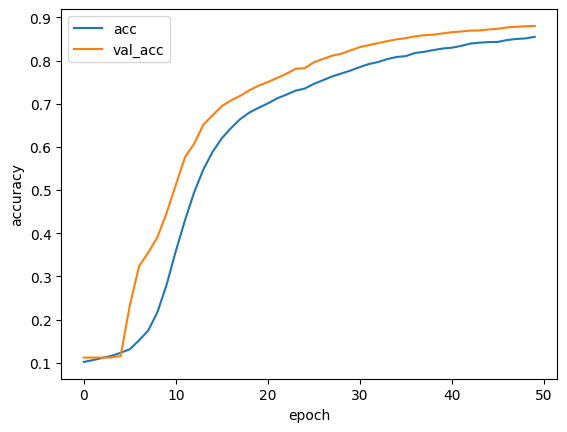

In [90]:
# グラフの表示
plt.plot(history['acc'], label='acc')
plt.plot(history['val_acc'], label='val_acc')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(loc='best')
plt.show()

In [91]:
# 評価
model.eval()
test_loss = 0
test_correct = 0
test_total = 0

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        loss = criterion(outputs, labels)
        test_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        test_total += labels.size(0)
        test_correct += (predicted == labels).sum().item()

test_loss = test_loss / len(test_loader)
test_acc = test_correct / test_total
print('loss: {:.3f}\nacc: {:.3f}'.format(test_loss, test_acc))

loss: 0.406
acc: 0.879


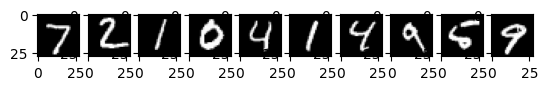

In [92]:
# 推論する画像の表示
for i in range(10):
    plt.subplot(1, 10, i+1)
    plt.imshow(test_images[i].reshape((28, 28)), 'gray')
plt.show()

In [93]:
# 推論する画像のラベル
print(test_labels2[0:10])

[7 2 1 0 4 1 4 9 5 9]


In [94]:
# 推論したラベルの表示
model.eval()
with torch.no_grad():
    test_images_tensor = torch.FloatTensor(test_images_processed[0:10]).to(device)
    test_predictions = model(test_images_tensor)
    test_predictions = torch.argmax(test_predictions, dim=1).cpu().numpy()
    print(test_predictions)

[7 2 1 0 4 1 4 9 6 9]
